In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import keras_tuner as kt
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/solarenergy/Solar_Energy.csv')

In [3]:
start_date = pd.to_datetime('2022-06-07 00:00')

df['Time'] = pd.date_range(start=start_date, periods=len(df), freq='h')

In [4]:
df

,Time,SolarEnergy
0,2022-06-07 00:00:00,-0.001770
1,2022-06-07 01:00:00,-0.001242
2,2022-06-07 02:00:00,-0.001240
3,2022-06-07 03:00:00,-0.001237
4,2022-06-07 04:00:00,-0.001237
...,...,...
5248,2023-01-11 16:00:00,0.582284
5249,2023-01-11 17:00:00,0.033335
5250,2023-01-11 18:00:00,-0.004973
5251,2023-01-11 19:00:00,-0.002501


In [5]:
df.loc[df['SolarEnergy'] <= 0, 'SolarEnergy'] = 0

In [46]:
df[df.SolarEnergy < 0].shape[0]

0

In [7]:
def create_dataset(serie, time_steps=1):
    Xs, ys = [], []
    for i in range(len(serie) - time_steps):
        Xs.append(serie.iloc[i:(i + time_steps)].values)
        ys.append(serie.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [8]:
time_steps = 15
X, y = create_dataset(df.SolarEnergy, time_steps)
X_scaled = MinMaxScaler().fit_transform(X)


In [9]:
names = [f"X{i}" for i in range(15)]
data = pd.DataFrame(X_scaled, columns=names)
data["Y"] = MinMaxScaler().fit_transform(y.reshape(-1, 1))
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.0,0.000000,0.000000,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266
1,0.0,0.000000,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503
2,0.0,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605
3,0.0,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605,0.095862
4,0.0,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605,0.095862,0.005332


In [10]:
X.shape

(5238, 15)

In [11]:
X_resh = X_scaled.reshape(len(X), time_steps,1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resh, y,test_size = 0.1, random_state=42, shuffle=False)

In [13]:
window_size = time_steps

In [14]:
val_loss = {
    'Simple RNN': 0,
    'LSTM': 0,
    'BILSTM': 0,
    'GRU': 0
}

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [16]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

    
def model_builder_simpleRNN(hp):
    model = tf.keras.Sequential()

    # hyperparameters
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'tanh'])

    model.add(tf.keras.layers.SimpleRNN(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')

    return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# run the search with GPU
with strategy.scope():
    tuner_simRNN = kt.Hyperband(
        model_builder_simpleRNN,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='simpleRNN'
    )


tuner_simRNN.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

best_hps_simRNN = tuner_simRNN.get_best_hyperparameters(num_trials=1)[0]
best_trial_simRNN = tuner_simRNN.oracle.get_best_trials(num_trials=1)[0]
val_loss = {}
val_loss['Simple RNN'] = best_trial_simRNN.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
The validation loss is: {val_loss['Simple RNN']:.6f}
Best number of units: {best_hps_simRNN.get('units')}
Best learning rate: {best_hps_simRNN.get('learning_rate')}
Best activation: {best_hps_simRNN.get('activation')}
""")


Trial 30 Complete [00h 00m 09s]
val_loss: 0.2586144804954529

Best val_loss So Far: 0.03564295172691345
Total elapsed time: 00h 02m 47s

The validation loss is: 0.035643
Best number of units: 160
Best learning rate: 0.01
Best activation: relu



In [17]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_lstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.LSTM(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1))  # Output layer

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


with strategy.scope():
    tuner_LSTM = kt.Hyperband(
        model_builder_lstm,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='lstm'
    )

# run the search with GPU
tuner_LSTM.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
    callbacks=[stop_early]
)

# Retrieve best hyperparameters and validation loss
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
best_trial_LSTM = tuner_LSTM.oracle.get_best_trials(num_trials=1)[0]

val_loss['LSTM'] = best_trial_LSTM.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
LSTM Validation Loss: {val_loss['LSTM']:.6f}
Optimal Units: {best_hps_LSTM.get('units')}
Optimal Learning Rate: {best_hps_LSTM.get('learning_rate')}
Optimal Activation: {best_hps_LSTM.get('activation')}
""")


Trial 30 Complete [00h 00m 08s]
val_loss: 0.09139387309551239

Best val_loss So Far: 0.03221133351325989
Total elapsed time: 00h 03m 02s

LSTM Validation Loss: 0.032211
Optimal Units: 256
Optimal Learning Rate: 0.01
Optimal Activation: tanh



In [18]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_Bilstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) 

    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=hp_units, activation=hp_activation),
        input_shape=(window_size, 1)
    ))
    model.add(tf.keras.layers.Dense(1)) 

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# run the search with GPU
with strategy.scope():

    tuner_Bidirectional = kt.Hyperband(
    model_builder_Bilstm,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='Bilstm'
    )
    
tuner_Bidirectional.search(
    X_train, y_train, epochs=50, validation_data=(X_test, y_test),
    callbacks=[stop_early]
)


best_hps_Bidirectional = tuner_Bidirectional.get_best_hyperparameters(num_trials=1)[0]
best_trial_Bidirectional = tuner_Bidirectional.oracle.get_best_trials(num_trials=1)[0]
val_loss['BILSTM'] = best_trial_Bidirectional.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
BiLSTM Validation Loss: {val_loss['BILSTM']:.6f}
Optimal Units: {best_hps_Bidirectional.get('units')}
Optimal Learning Rate: {best_hps_Bidirectional.get('learning_rate')}
Optimal Activation: {best_hps_Bidirectional.get('activation')}
""")


Trial 30 Complete [00h 00m 16s]
val_loss: 0.028744297102093697

Best val_loss So Far: 0.027908138930797577
Total elapsed time: 00h 04m 33s

BiLSTM Validation Loss: 0.027908
Optimal Units: 288
Optimal Learning Rate: 0.01
Optimal Activation: tanh



In [19]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_gru(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.Reshape((window_size, 1), input_shape=[window_size]))
    model.add(tf.keras.layers.GRU(units=hp_units, activation=hp_activation))
    model.add(tf.keras.layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')
    return model

# run the search with GPU
with strategy.scope():
    tuner_GRU = kt.Hyperband(
        model_builder_gru,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='gru'
    )


tuner_GRU.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

best_hps_GRU = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]
best_trial_GRU = tuner_GRU.oracle.get_best_trials(num_trials=1)[0]
val_loss['GRU'] = best_trial_GRU.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
GRU Validation Loss: {val_loss['GRU']}
Optimal Units: {best_hps_GRU.get('units')}
Optimal Learning Rate: {best_hps_GRU.get('learning_rate')}
Optimal Activation: {best_hps_GRU.get('activation')}
""")


Trial 30 Complete [00h 00m 11s]
val_loss: 0.2948029339313507

Best val_loss So Far: 0.028422489762306213
Total elapsed time: 00h 03m 44s

GRU Validation Loss: 0.028422489762306213
Optimal Units: 512
Optimal Learning Rate: 0.01
Optimal Activation: relu



In [20]:
val_loss

{'Simple RNN': 0.03564295172691345,
 'LSTM': 0.03221133351325989,
 'BILSTM': 0.027908138930797577,
 'GRU': 0.028422489762306213}

In [21]:
best_model_rnn = tuner_simRNN.get_best_models(num_models = 1)[0]
best_model_lstm = tuner_LSTM.get_best_models(num_models = 1)[0]
best_model_bilstm = tuner_Bidirectional.get_best_models(num_models = 1)[0]
best_model_gru = tuner_GRU.get_best_models(num_models = 1)[0]

In [22]:
best_models = [best_model_rnn, best_model_lstm, best_model_bilstm, best_model_gru]
histories = []
for model in best_models:
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)
    histories.append(history)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1269 - val_loss: 0.0421
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1045 - val_loss: 0.0389
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0804 - val_loss: 0.0397
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1025 - val_loss: 0.0320
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0976 - val_loss: 0.0428
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0895 - val_loss: 0.0310
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - val_loss: 0.0341
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1009 - val_loss: 0.0298
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0911 - val_loss: 0.0332
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1009 - val_loss: 0.0394
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0981 - val_loss: 0.0391
Epoch 12/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

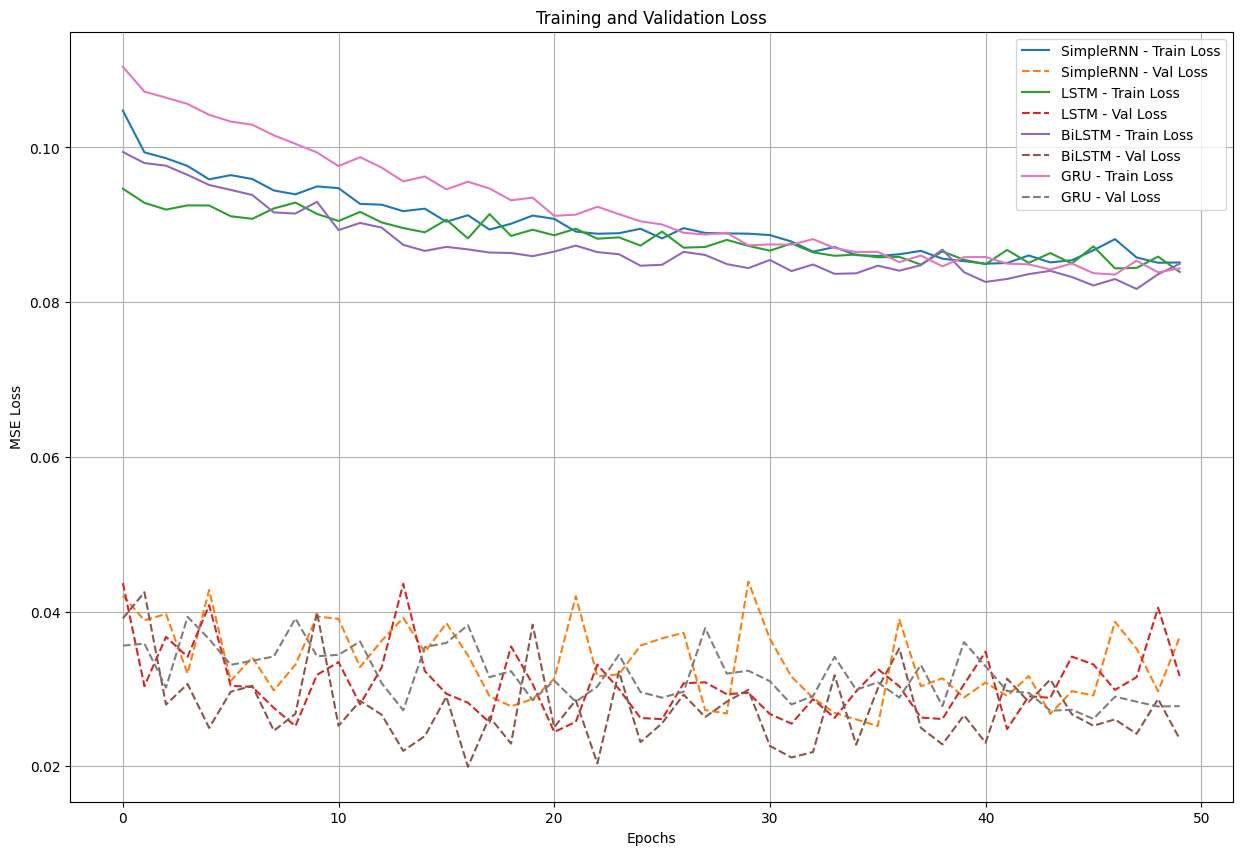

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_error

model_names = ['SimpleRNN', 'LSTM', 'BiLSTM', 'GRU']
r2_scores = {}
mse_scores = {}
mae_scores = {}

plt.figure(figsize=(15, 10))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Val Loss', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


for i, model in enumerate(best_models):
    y_preds = model.predict(X_test).flatten()
    
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)

    r2_scores[model_names[i]] = r2
    mse_scores[model_names[i]] = mse
    mae_scores[model_names[i]] = mae



results = pd.DataFrame({
    'model': list(r2_scores.keys()),
    'r2': list(r2_scores.values()),
    'mse': list(mse_scores.values()),
    'mae': list(mae_scores.values())
})


In [24]:
results

,model,r2,mse,mae
0,SimpleRNN,0.966604,0.036704,0.111876
1,LSTM,0.971188,0.031666,0.104253
2,BiLSTM,0.978589,0.023532,0.083140
3,GRU,0.974722,0.027782,0.093002


In [49]:
import joblib


use_r2 = False

if use_r2:
    best_model_name = max(r2_scores, key=r2_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on R²: {best_model_name} ({r2_scores[best_model_name]:.6f})")
else:
    best_model_name = min(mse_scores, key=mse_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on MSE: {best_model_name} ({mse_scores[best_model_name]:.6f})")

best_model = best_models[best_model_index]

best_model.save(f'best_model_{best_model_name}.h5')
print(f"Model saved as best_model_{best_model_name}.h5")


Best model based on MSE: BiLSTM (0.023532)
Model saved as best_model_BiLSTM.h5


# Loaanding and testing the model

In [26]:
df

,Time,SolarEnergy
0,2022-06-07 00:00:00,0.000000
1,2022-06-07 01:00:00,0.000000
2,2022-06-07 02:00:00,0.000000
3,2022-06-07 03:00:00,0.000000
4,2022-06-07 04:00:00,0.000000
...,...,...
5248,2023-01-11 16:00:00,0.582284
5249,2023-01-11 17:00:00,0.033335
5250,2023-01-11 18:00:00,0.000000
5251,2023-01-11 19:00:00,0.000000


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


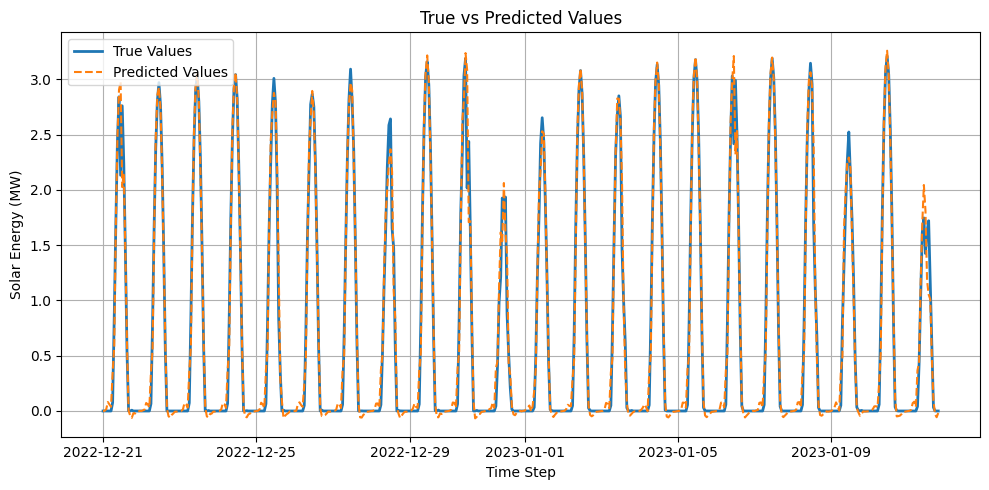

In [29]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

model = load_model('/kaggle/working/best_model_BiLSTM.h5', custom_objects={'mse': MeanSquaredError()})
y_pred = model.predict(X_test).flatten()


plt.figure(figsize=(10, 5))
plt.plot(df.Time[5252-524:5252],y_test, label='True Values', linewidth=2)
plt.plot(df.Time[5252-524:5252],y_pred, label='Predicted Values', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 1) Forcasting the 22 of future

In [30]:
future = pd.DataFrame()
future['SolarEnergy'] = y_pred
future

,SolarEnergy
0,-0.000788
1,0.001898
2,0.016060
3,0.081223
4,0.058643
...,...
519,0.486694
520,0.095899
521,-0.029971
522,-0.056379


In [47]:
future.loc[future['SolarEnergy'] <= 0, 'SolarEnergy'] = 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


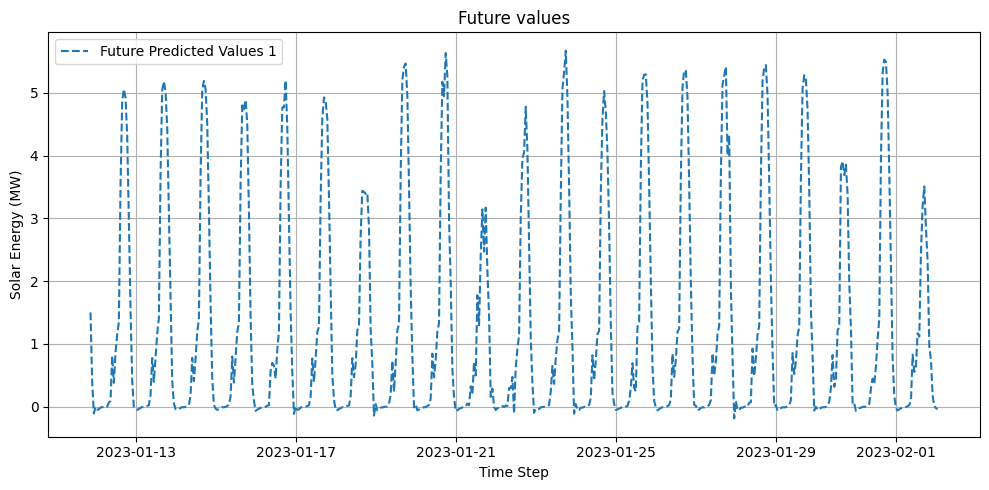

In [50]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError


model = load_model('/kaggle/working/best_model_BiLSTM.h5', custom_objects={'mse': MeanSquaredError()})
X, y = create_dataset(future.SolarEnergy, time_steps)
y_pred1 = model.predict(MinMaxScaler().fit_transform(X)).flatten()


plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h'),y_pred1, label='Future Predicted Values 1', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) next 22 days

In [51]:
pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h')[-1]

Timestamp('2023-02-02 01:00:00')

In [52]:
future2 = pd.DataFrame()
future2['SolarEnergy'] = y_pred1
future2

,SolarEnergy
0,1.501667
1,0.385491
2,-0.108549
3,-0.006125
4,-0.050440
...,...
504,0.733808
505,0.171516
506,0.012618
507,-0.026368


In [54]:
future2.loc[future2['SolarEnergy'] <= 0, 'SolarEnergy'] = 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


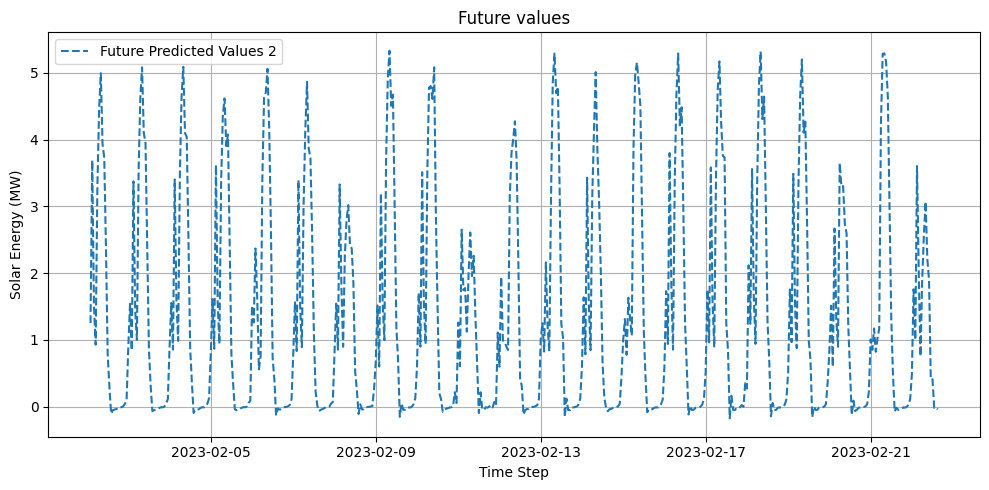

In [55]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

X, y = create_dataset(future2.SolarEnergy, time_steps)
y_pred2 = model.predict(MinMaxScaler().fit_transform(X)).flatten()

plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-02-02 02:00:00', periods = len(y_pred2), freq='h'),y_pred2, label='Future Predicted Values 2', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving model and directory

In [57]:
import shutil


shutil.make_archive('/kaggle/working/my_dir', 'zip', '/kaggle/working/')


'/kaggle/working/my_dir.zip'